# Hotkeys  
- `A`, `B` front and back
- `ESC`, `ENTER` writing or commands
- `M`, `Y` md and code 


# Start

In [1]:
#r "nuget: Microsoft.Data.Analysis, 0.21.1"
#r "nuget: ScottPlot, 5.0.36"

using System;
using System.Reflection;

using Microsoft.DotNet.Interactive.Formatting;

using Microsoft.Data.Analysis;

using Newtonsoft.Json;

bool DEBUG = true;

Installed Packages Microsoft.Data.Analysis, 0.21.1 ScottPlot, 5.0.36

Loading extensions from `C:\Users\jvh\.nuget\packages\microsoft.data.analysis\0.21.1\interactive-extensions\dotnet\Microsoft.Data.Analysis.Interactive.dll`

Loading extensions from `C:\Users\jvh\.nuget\packages\skiasharp\2.88.8\interactive-extensions\dotnet\SkiaSharp.DotNet.Interactive.dll`

In [ ]:
Formatter.Register(typeof(ScottPlot.Plot), (p, w) => w.Write(((ScottPlot.Plot)p).GetImageHtml(400, 300)), HtmlFormatter.MimeType);

class PlotBuilder {
    ScottPlot.Plot plot;

    public PlotBuilder (string title = "") {
        plot = new ();
        plot.Axes.Title.Label.Text = title;
    }

    public PlotBuilder Add<T1, T2> (List<T1> x, List<T2> y, string legend = default) {
        plot.Add.Scatter(x, y).LegendText = legend ?? "";
        return this;
    }
    public PlotBuilder Add<T> (List<T> y, string legend = default) => Add(Enumerable.Range(0, y.Count).ToList(), y, legend);
    public PlotBuilder Add<T> (List<(T,T)> y, (string, string) legend = default) =>
         Add(y.Select(y => y.Item1).ToList(), legend.Item1)
        .Add(y.Select(y => y.Item2).ToList(), legend.Item2);
    public PlotBuilder Add<T> (List<(T,T,T)> y, (string, string, string) legend = default) => 
         Add(y.Select(y => y.Item1).ToList(), legend.Item1)
        .Add(y.Select(y => y.Item2).ToList(), legend.Item2)
        .Add(y.Select(y => y.Item3).ToList(), legend.Item3);
    public PlotBuilder Add<T> (List<(T,T,T,T)> y, (string, string, string, string) legend = default) => 
         Add(y.Select(y => (y.Item1, y.Item2, y.Item3)).ToList(), (legend.Item1, legend.Item2, legend.Item3))
        .Add(y.Select(y => y.Item4).ToList(), legend.Item4);

    public PlotBuilder LimitY(double y0, double y1) {
        plot.Axes.SetLimitsY(y0, y1);
        return this;
    } 
    public PlotBuilder Limit(double x0, double x1, double y0, double y1) {
        plot.Axes.SetLimits(x0, x1, y0, y1);
        return this;
    }
    public PlotBuilder LimitH(double h) => LimitY(0, h); 

    public ScottPlot.Plot Build ()  {  
        //plot.Axes.SetLimits(0, 1000);
        return plot; 
    }
}

In [ ]:
static string DumpS(this object value) => value is not string ? JsonConvert.SerializeObject(value, Formatting.None) : value as string;

static T[] DumpMulti<T> (this T[] values) {
    values.ToList().ForEach(item => item.Dump());
    return values;  
} 
static IEnumerable<T> DumpMulti<T> (this IEnumerable<T> values) {
    values.ToList().ForEach(item => item.Dump());
    return values;
} 
static T Dump<T>(this T value) => DumpOneLine(value);

static T DumpOneLine<T> (this T value) {
    Console.WriteLine(value.DumpS());
    return value;
}
static void Log(this object item) => Console.WriteLine(item);

In [ ]:
static BindingFlags flags = BindingFlags.Public | BindingFlags.Instance;

static DataFrame CreateDataFrame (IEnumerable<object> values) {
    Type type = values.First().GetType();

    if (type.IsPrimitive)
        return DataFrame.LoadFrom(values.Select(i => new List<object>() { i }), new List<(string, Type)>() { ("", type)});

    FieldInfo[] fields = type.GetFields(flags);
    PropertyInfo[] properties = type.GetProperties(flags);

    IEnumerable<DataFrame> dataFields = fields.Select(field => CreateDataFrame(values.Select(field.GetValue)).AddPrefix($"{field.Name} ", inPlace: true));
    IEnumerable<DataFrame> dataProperties = properties.Select(property => CreateDataFrame(values.Select(property.GetValue)).AddPrefix($"{property.Name} ", inPlace: true));
    IEnumerable<DataFrameColumn> columns = new [] { dataFields, dataProperties }.SelectMany(frames => frames).SelectMany(frame => frame.Columns);
    return new DataFrame(columns);
}
static DataFrame CreateDataFrame<T> (IEnumerable<T> values) => CreateDataFrame(values.Select(i => (object)i));

static DataFrame ToDataFrame<T>(this IEnumerable<T> objects, params (int index, string name)[] names) {
    FieldInfo[] fields = typeof(T).GetFields();

    string[] prefixes = new string[fields.Length];
    foreach (var t in names) 
        prefixes[t.index] = t.name;

    IEnumerable<DataFrame> dataFrames = fields.Select((field, i) => CreateDataFrame(objects.Select(obj => field.GetValue(obj))).AddPrefix(prefixes[i], inPlace: true));
    IEnumerable<DataFrameColumn> columns = dataFrames.SelectMany(df => df.Columns);

    return new DataFrame(columns);
} 
static DataFrame ToDataFrame<T>(this IEnumerable<T> objects, string prefix = "")    => CreateDataFrame(objects.ToList()).AddPrefix(prefix, inPlace: true); 
static DataFrame ToDataFrame<T>(this List<T> objects, string prefix = "")           => CreateDataFrame(objects).AddPrefix(prefix, inPlace: true); 
static DataFrame Concat(this DataFrame df, DataFrame added, string prefix = "" )    => new DataFrame(df.Columns.Concat(added.Clone().AddPrefix(prefix).Columns));

In [ ]:
Random random = new Random(29);

float NextGauss (float mean, float stdDev) {
    float u1 = 1.0f - random.NextSingle();
    float u2 = 1.0f - random.NextSingle();
    float randStdNormal = (float)Math.Sqrt(-2.0f * Math.Log(u1)) * (float)Math.Sin(2.0f * Math.PI * u2); 
    float randNormal = mean + stdDev * randStdNormal; 
    return randNormal;
}
float NextGauss (float mu, float sigma, float min, float max) {
    float x;
    do
    {
        x = NextGauss(mu, sigma);
    } while (x < min || x > max);

    return x;
}

# Simulation

In [ ]:
using number_t = float;
const int SIMULATION_STEPS = 1_000;
const int CAPUTURE_STEPS = 10;

public struct Market
{
    public number_t Food, Oxygen, Minerals, Water;
}

public struct MarketF
{
    public float Food, Oxygen, Minerals, Water;
}

public struct Population
{
    public number_t Farmers, Laborers, Engineers;
    public number_t Children;
    public number_t Unemployed;
    public number_t Total => Farmers + Laborers + Engineers + Children + Unemployed;
    //public float FarmersNeed, LaborersNeed, EngineersNeed;
}


public struct Infrastructure 
{
    public number_t Rail, Water, Air;
}
public struct Technology 
{
    public number_t Input, Output;
}

public struct Points 
{
    public int Value;
}

struct SimulationState {
    public Market Market;
    public Market Surplus;
    public MarketF Ratio;
    public Population Population;
    public Infrastructure Infrastructure;
    public Technology Technology;
}

In [ ]:
static Market sub(Market a, Market b) => new Market
{
    Food     = a.Food     - b.Food,
    Oxygen   = a.Oxygen   - b.Oxygen,
    Minerals = a.Minerals - b.Minerals,
    Water    = a.Water    - b.Water
};
static MarketF divF(Market a, Market b) => new MarketF
{
    Food     = (float) a.Food     / b.Food,
    Oxygen   = (float) a.Oxygen   / b.Oxygen,
    Minerals = (float) a.Minerals / b.Minerals,
    Water    = (float) a.Water    / b.Water
};
static Market min (Market a, Market b) => new Market
{
    Food     = Math.Min(a.Food,     b.Food),
    Oxygen   = Math.Min(a.Oxygen,   b.Oxygen),
    Minerals = Math.Min(a.Minerals, b.Minerals),
    Water    = Math.Min(a.Water,    b.Water)
};
static Market mul (Market a, number_t k) => new Market
{
    Food     = a.Food     * k,
    Oxygen   = a.Oxygen   * k,
    Minerals = a.Minerals * k,
    Water    = a.Water    * k
};

In [ ]:
void Produce(in Population population, in Technology technology, out Market market)
{
    market.Food = population.Farmers* 5;
    market.Minerals = population.Laborers;
    market.Oxygen = population.Engineers * 100;
    market.Water = population.Engineers * 20;
}

In [ ]:
void Births (float deathRate, ref Population population) {
    float decrease = Math.Clamp(1 - deathRate, 0.8f, 1);
    float increase = 0.02f;//Math.Clamp(NextGauss(0.0002f, 0.0001f), 0, 0.01f);

    number_t births = (number_t)Math.Floor(population.Total * increase);
    number_t deaths = 0;
    number_t emigration = 0;
    number_t immigration = 0;  

    population.Children =  (number_t)Math.Floor(population.Total * increase);

    population.Farmers   = (number_t)Math.Floor(population.Farmers   * decrease);
    population.Laborers  = (number_t)Math.Floor(population.Laborers  * decrease);
    population.Engineers = (number_t)Math.Floor(population.Engineers * decrease);
} 

In [ ]:
void Promote (in MarketF ratios, ref Population population) {
    /* This makes it faster
    if (ratios.Oxygen < 1.2 || ratios.Water < 1.2) {
        number_t promotions = (number_t)Math.Floor(population.Laborers * 0.1f);
        population.Laborers -= promotions;
        population.Engineers += promotions;
    }//*/
    
    // children
    if (ratios.Oxygen < 1 || ratios.Water < 1)
        population.Engineers += population.Children;
    else if (ratios.Food < 1)
        population.Farmers += population.Children;
    else
        population.Unemployed += population.Children;
}

In [ ]:
void Consume(in Market market, ref Population population, out MarketF ratio, out Market surplus)
{
    number_t pops = population.Total;
    
    Market need = new();
    need.Oxygen = pops * 2;
    need.Food   = pops;
    need.Water  = pops;

    Market bought = min(market, need);

    surplus = sub(market, bought);

    ratio = divF(bought, need);
}


In [2]:
void SimulateStep (ref SimulationState state) {
    Produce(in state.Population, out state.Market);
    Consume(in state.Market, ref state.Population, out state.Ratio, out state.Surplus);
    Promote(in state.Ratio, ref state.Population);
    Births(1 - state.Ratio.Oxygen, ref state.Population);
}

List<SimulationState> steps = new() { new () { Population = new Population { Engineers = 10, Farmers = 10, Laborers = 1000 }} };
SimulationState state = steps.First();
for (int i = 0; i < SIMULATION_STEPS; i++) {
    SimulateStep(ref state);
    if (i % CAPUTURE_STEPS == 0)
        steps.Add(state);
}

Error: (1,24): error CS0246: The type or namespace name 'SimulationState' could not be found (are you missing a using directive or an assembly reference?)
(8,6): error CS0246: The type or namespace name 'SimulationState' could not be found (are you missing a using directive or an assembly reference?)
(9,1): error CS0246: The type or namespace name 'SimulationState' could not be found (are you missing a using directive or an assembly reference?)
(8,65): error CS0246: The type or namespace name 'Population' could not be found (are you missing a using directive or an assembly reference?)
(10,21): error CS0103: The name 'SIMULATION_STEPS' does not exist in the current context
(12,13): error CS0103: The name 'CAPUTURE_STEPS' does not exist in the current context
(2,5): error CS0103: The name 'Produce' does not exist in the current context
(3,5): error CS0103: The name 'Consume' does not exist in the current context
(4,5): error CS0103: The name 'Promote' does not exist in the current context
(5,5): error CS0103: The name 'Births' does not exist in the current context

# Results

## Populations

Theory
$\delta p = $ birhts - deaths where deaths is set by oxygen. births is limited by utilities

In [ ]:
List<int> declines = Enumerable.Range(0, steps.Count - 1).Where((i) => steps[i].Population.Total > steps[i + 1].Population.Total).ToList();
List<Population> populations = steps.Select(s => s.Population).ToList();

new object[] {$"Simulation Completed with {declines.Count} declines", steps.Last().Population.Total, steps.Last().Population, steps.Last().Market, declines.Select(i => new [] {populations[i], populations[i + 1]})}

index type value 0 System.String Simulation Completed with 2 declines 1 System.Single 3.120317E+11 2 Submission#9+Population Submission#9+Population Total 3.120317E+11 Farmers 6.391832E+10 Laborers 640 Engineers 1.9177337E+10 Children 6.23814E+09 Unemployed 2.2269791E+11 3 Submission#9+Market Submission#9+Market Food 3.195916E+11 Oxygen 1.9177337E+12 Minerals 640 Water 3.8354675E+11 4 System.Linq.Enumerable+SelectListIterator<System.Int32,Submission#9+Population[]> index value 0 index value 0 Submission#9+Population Total 1020 Farmers 10 Laborers 1000 Engineers 10 Children 0 Unemployed 0 1 Submission#9+Population Total 836 Farmers 8 Laborers 800 Engineers 8 Children 20 Unemployed 0 1 index value 0 Submission#9+Population Total 836 Farmers 8 Laborers 800 Engineers 8 Children 20 Unemployed 0 1 Submission#9+Population Total 818 Farmers 108 Laborers 640 Engineers 54 Children 16 Unemployed 0


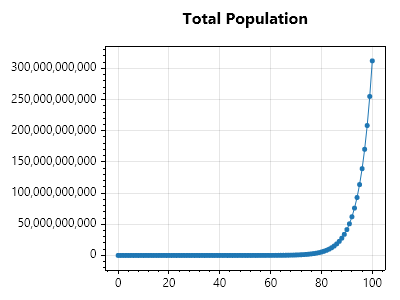

In [ ]:
new PlotBuilder("Total Population").Add(populations.Select(pop => pop.Total).ToList()).Build()

In [3]:
new PlotBuilder("Population groups").Add(populations.Select(pop => (pop.Farmers, pop.Laborers, pop.Engineers)).ToList(), ("F", "L", "E")).Build()

Error: (1,5): error CS0246: The type or namespace name 'PlotBuilder' could not be found (are you missing a using directive or an assembly reference?)
(1,42): error CS0103: The name 'populations' does not exist in the current context

In [4]:
new PlotBuilder("Population Log10").Add(populations.Select(pop => (Math.Log(pop.Farmers), Math.Log(pop.Laborers), Math.Log(pop.Engineers))).ToList(), ("F", "L", "E")).LimitH(50).Build()

Error: (1,5): error CS0246: The type or namespace name 'PlotBuilder' could not be found (are you missing a using directive or an assembly reference?)
(1,41): error CS0103: The name 'populations' does not exist in the current context

## Markets

$\Delta price = $  goes up when supply is met, goes down when not 

## New Testing

# Politics

## What do i want
I want representation and discourse, disagreement.
I want it to be local and state wide. 

Beurocracy is a mess, but necessary 

## How do we get it 

Decisision should be based on local factors as geography and populations.
It should be implemented as representatives from different governments.


Three tier of government like NUTS
